# Logistic Regression

Logistic regression is a *classification algorithm*.

Text(0.5, 1.0, 'Data representation')

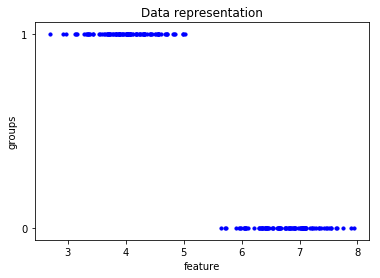

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


# create linearly separable data
sep = False
while not sep:
    X, Y = make_blobs(n_samples=200, n_features
                      =1, centers=2, cluster_std=0.5, center_box=(0, 10))
    sep = True
    for x_1 in X[Y == 1]:
        for x_0 in X[Y == 0]:
            if Y[X.argmin()] == 0 and x_0 > x_1:
                sep = False
            elif x_0 < x_1:
                sep = False
                
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

plt.scatter(X, Y, s=10, c='b')
plt.xlabel('feature')
plt.ylabel('groups')
plt.yticks([0, 1])
plt.title('Data representation')

## Model

We have to fit a **model** trough our data.  
A *sigmoid* (also called *logistic*) function is used:
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

It produce an 'S' shape like function that stays between 0 and 1

Text(0.5, 1.0, 'Sigmoid function')

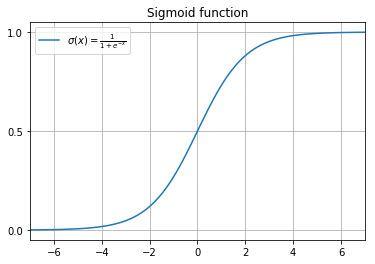

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

xs = np.linspace(-7, 7, 100)
ys = sigmoid(xs)
plt.plot(xs, ys, label=r'$\sigma(x) = {\frac{1}{1 + e^{-x}}}$')
plt.yticks([0, 0.5, 1])
plt.xlim([-7, 7])
plt.legend()
plt.grid()
plt.title('Sigmoid function')

Text(0.5, 1.0, 'Approximation')

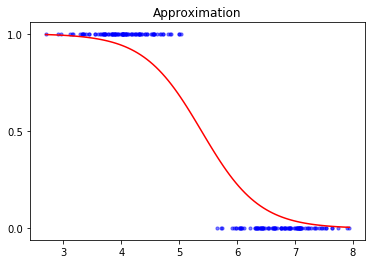

In [3]:
#  helper function for approximation
def sigmoid_mu_s(x, mu, s):
    return 1 / (1 + np.exp(-(x + mu) / s))

plt.scatter(X, Y, s=10, c='b', alpha=0.5)
sig_x = np.linspace(X.min(), X.max(), 100)
y_flip = 1 if Y[X.argmin()] == 0 else -1
sig_y = sigmoid_mu_s(sig_x, -X.mean(), y_flip * 0.5)
plt.plot(sig_x, sig_y, c='r')
plt.yticks([0, 0.5, 1])
plt.title('Approximation')

## Hypothesis and Prediction

We can tweak the sigmoid function by passing the dot product of $x$ (vector of feature) and $\theta$ (the vector of weights).

$$h(x) = \sigma(x \cdot \theta) = \sigma(\theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_n x_n)$$
$x_0$ being equal to 1.  
$\theta$ is not a parameter of $h$ because it's considered as a constant.

$h$ is our hypothesis function. It return a probability of an $x$ to belong to one of the group.  
To predict some new $x$ we input it to $h$ with the weights and see if the returned value if above or below 0.5.

$$
\text{prediction} =
    \begin{cases} 
        1, & h(x) \ge 0.5 \\
        0, & h(x) \lt 0.5
    \end{cases}
$$

This is equivalent to:

$$
\text{prediction} =
    \begin{cases} 
        1, & x \cdot \theta \ge 0 \\
        0, & x \cdot \theta \lt 0
    \end{cases}
$$

Indeed, in the sigmoid funcion:  
* $x$ is *above* 0 then $e^{-x}$ tend to be small, $\frac{1}{1 + \text{small number}} \approx 1$.  
* $x$ is *below* 0 then $e^{-x}$ tend to be big, $\frac{1}{1 + \text{big number}} \approx 0$. 

Therefore, a prediction can be visualized by projecting $x$ onto $\theta$.  
It will be more relevant the more the two vectors go in the same direction
(or opposite direction for negative projection),
for exemple if $x \cdot \theta = 0$ then $x$ is perpendicular to $\theta$,
$h(x) = 0.5$ right in the middle of the sigmoid function,
the prediction become more irelevant as $x \cdot \theta$ tend to 0.

In [4]:
def hypothesis(x, theta):
    # suppose that x_0 = 1 and isn't mentionned
    return sigmoid(theta[0] + x.dot(theta[1:]))


def predict(x, theta):
    return int(hypothesis(x, theta) >= 0.5)  #  a bit more clear
    # or
    return int(theta[0] + x.dot(theta[1:]) >= 0)
    # there is a nice vector interpretation for this one
    # and it probably compute faster

## Cost function

We have to evaluate our model by introducing a cost function, this one is called the *logloss*

For a single $x$:
$$
j(h(x), y) = 
    \begin{cases} 
        -\ln(h(x)),     & y = 1 \\
        -\ln(1 - h(x)), & y = 0 
    \end{cases}
$$
It can be rewritten as a single continuous function:
$$ j(h(x), y) = -y \ln(h(x)) - (1 - y) \ln(1 - h(x))$$

Even if it may seem more complicated at first sight, it's just a switch with the values of $y$.  
- if $y = 1$ then $- (1 - y) \ln(1 - h(x)) = 0$ and the $-\ln(h(x))$ stays.
- if $y = 0$ then $-y \ln(h(x)) = 0$            and the $-\ln(1 - h(x))$ stays.

Text(0.5, 1.0, 'cost function')

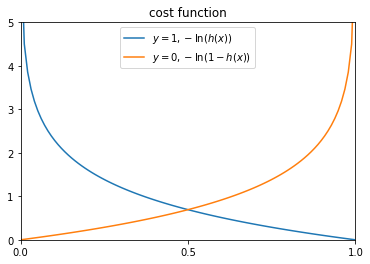

In [5]:
xs = np.linspace(0.001, 0.999, 100)
ys_0 = [-np.log(1 - x) for x in xs]
ys_1 = [-np.log(x) for x in xs]
plt.plot(xs, ys_1, label=r'$y = 1, -\ln(h(x))$')
plt.plot(xs, ys_0, label=r'$y = 0, -\ln(1 - h(x))$')
plt.ylim([0, 5])
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.legend()
plt.title('cost function')

In [6]:
def logloss(x, y, theta):
    if y == 1:
        return -np.log(hypothesis(x, theta))
    elif y == 0:
        return -np.log(1 - hypothesis(x, theta))
    #  or (less obvious)
    return -y * np.log(hypothesis(x, theta)) - (1 - y) * np.log(1 - hypothesis(x, theta))

We can see that if $y$ was suppose to be 0 but is close to 1, the cost will be high.  
Same logic if $y$ was suppose to be 1 but is close to 0.

Then we generalize the cost function for all $x$:
$$J(\theta) = \frac{1}{n} \sum_{i = 1}^{n} j(h(x_i), y_i)$$
$n$ is the number of elements in $X$ and $Y$.

In [7]:
def cost(xs, ys, theta):
    return sum([logloss(x, y, theta) for x, y in zip(xs, ys)]) / len(xs)

## Optimization

### Gradient descent

Finally, use gradient descent to minimize the cost function:

$$\theta_i := \theta_i - \alpha \frac{\partial}{\partial \theta_i} J(\theta)\ \text{ for } i = 1, ..., n$$

Or with gradient notation:

$$ \theta := \theta - \alpha \nabla J(\theta)$$


$\alpha$ is the learning rate (how fast we want the step to be).  
Since $\theta_i$ is only used in the dot product, all of them will have similar partial derivative.

let $z = x \cdot \theta_j$

$\newcommand{\pt}{\frac{\partial}{\partial \theta_j}}$
$$
\begin{align}
      & \pt J(\theta) \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n} j(h(x_i, \theta), y_i) \right] \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n}
        (-y_i \ln(h(x_i, \theta)) - (1 - y_i) \ln(1 - h(x_i, \theta))) \right] \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n}
        (-y_i \ln(\sigma(z)) - (1 - y_i) \ln(1 - \sigma(z))) \right] \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n}
        (-y_i \ln(\frac{1}{1 + e^{-z}}) -
        (1 - y_i) \ln(1 - \frac{1}{1 + e^{-z}})) \right] \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \pt \left[ 
        -y_i \ln(\frac{1}{1 + e^{-z}}) -
        (1 - y_i) \ln(1 - \frac{1}{1 + e^{-z}}) \right] \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i \pt \left[ \ln(\frac{1}{1 + e^{-z}}) \right] -
        (1 - y_i) \pt \left[ \ln(1 - \frac{1}{1 + e^{-z}}) \right] \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i(1 + e^{-z}) \pt \left[ \frac{1}{1 + e^{-z}} \right]
        - (1 - y_i) \frac{1}{1 - \frac{1}{1 + e^{-z}}} \pt \left[ 1 - \frac{1}{1 + e^{-z}} \right]
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i(1 + e^{-z}) \pt \left[ \frac{1}{1 + e^{-z}} \right]
        - (1 - y_i) \frac{1 + e^{-z}}{e^{-z}} (-1) \pt \left[ \frac{1}{1 + e^{-z}} \right]
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i(1 + e^{-z}) \frac{e^{-z}}{(1 + e^{-z})^2} \pt z
        - (1 - y_i) \frac{1 + e^{-z}}{e^{-z}} (-1) \frac{e^{-z}}{(1 + e^{-z})^2} \pt z
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i \frac{e^{-z}}{1 + e^{-z}} x_{ij}
        + (1 - y_i) \frac{1}{1 + e^{-z}} x_{ij}
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        \frac{-y_i e^{-z}}{1 + e^{-z}}
        + \frac{(1 - y_i)}{1 + e^{-z}} \right) x_{ij} \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        \frac{-y_i e^{-z} + 1 - y_i}{1 + e^{-z}} \right) x_{ij} \\
\end{align}
$$

$$
\boxed{
    = \frac{1}{n} \sum_{i = 1}^{n} \left( (h(x_i) - y_i) x_{ij} \right)
}$$

In [8]:
def cost_partial_theta(xs, ys, theta, theta_j):
    total = 0
    for x_i, y_i in zip(xs, ys):
        temp = hypothesis(x_i, theta) - y_i
        if theta_j != 0:
            temp *= x_i[theta_j - 1]
        total += temp
    return total / len(xs)


def cost_gradient(xs, ys, theta):
    return np.array([cost_partial_theta(xs, ys, theta, i)
                     for i in range(len(theta))])

In [18]:
def gradient_descent(xs, ys, theta, alpha=1, epoch=100):
    for _ in range(epoch):
        theta = theta - alpha * cost_gradient(xs, ys, theta)     
    return theta

In [39]:
theta = np.random.randn(len(X_train[0]) + 1)
theta = gradient_descent(X_train, Y_train, theta, 4, 500)
print('weights:  ', *theta)
print('train cost:', cost(X_train, Y_train, theta))
print('test cost: ', cost(X_test, Y_test, theta))

weights:   29.40983934878407 -5.527334155188794
train cost: 0.007186648908279271
test cost:  0.010992176598402464


Text(0.5, 1.0, 'Optimized model')

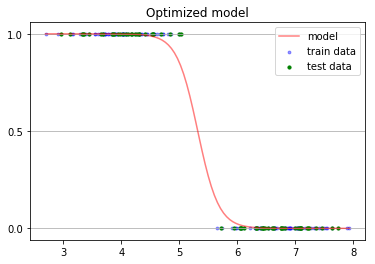

In [40]:
plt.scatter(X_train, Y_train, s=8, c='b', alpha=0.4, label='train data')
plt.scatter(X_test, Y_test, s=10, c='g', label='test data')
sig_x = np.linspace(X.min(), X.max(), 100)
sig_y = [hypothesis(np.array([x]), theta) for x in sig_x]
plt.plot(sig_x, sig_y, c='r', alpha=0.5, label='model')
plt.yticks([0, 0.5, 1])
plt.legend()
plt.grid(axis='y')
plt.title('Optimized model')